# Seq2seq model with Attention mechanism

[參考網址](https://github.com/soloice/tf-tutorial/blob/master/src/att_seq2seq_delete_and_copy.py)

##### 註：註解掉的部分為使用tensorboard才須執行的部分，若欲嘗試tensorboard也可將註解還原

## Import packages

In [1]:
import tensorflow as tf
import numpy as np
import random
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
# import argparse
# from tensorflow.contrib.tensorboard.plugins import projector

%matplotlib inline

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Helpers and parameters

In [2]:
# parser = argparse.ArgumentParser()
# parser.register("type", "bool", lambda v: v.lower() == "true")
# parser.add_argument(
#     "--copy",
#     type=bool,
#     default=True,
#     help="Whether or not to copy the sequence.")
# FLAGS, unparsed = parser.parse_known_args()

# only the parameter (origin FLAGS.copy) below would be used (where copying sequence or not)
cp_sequence = True

In [3]:
def plot_attention_matrix(src, tgt, matrix,
                          name="attention_matrix.png"):
    src = [str(item) for item in src]
    tgt = [str(item) for item in tgt]
    df = pd.DataFrame(matrix, index=src, columns=tgt)
    ax = sns.heatmap(df, linewidths=.5)
    ax.set_xlabel("target")
    ax.set_ylabel("source")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.set_title("Attention heatmap")
    plt.savefig(name, bbox_inches='tight')
    plt.gcf().clear()
#     plt.show()
    return matrix

In [1]:
vocab_size = 10 + 1 # 1~10 + 0
max_len = 48 # original max_len = 24, but the difference with/without attention is more subtle on acc
MAX_DECODE_STEP = max_len + 5
batch_size = 64
lr = 1e-2
PAD = 0
EOS = 0
GO = 0

odd_list, even_list = [1, 3, 5, 7, 9] * 10, [2, 4, 6, 8, 10] * 10

In [5]:
'''
input_x：產生隨機的奇偶數字(1~10，長度為2~max(len))，並且做padding使資料長度皆相同
output_y：只回傳input_x中偶數的部分(順序需相同，另外若copy_sequence=True時會需複製兩次)
          最後加入一個"0" 作為停止符號。亦作padding使資料長度相同

註：在此為簡化狀況，PAD的數字亦為0 (請見上個cell的參數設定)

length_x：回傳每個x的長度(未做padding前)
length_y：回傳每個y的長度(未做padding前)，長度為 length_x+1 (copy_sequence=False) | length_x*2+1 (copy_sequence=True)
'''

def generate_data(num_samples=batch_size, copy_sequence=True):
    num_odds = np.random.randint(low=1, high=max_len//2, size=num_samples)
    num_evens = np.random.randint(low=1, high=max_len//2, size=num_samples)
    batch_len_x = num_odds + num_evens
    if copy_sequence:
        batch_len_y = num_evens * 2 + 1  # append <EOS> (or prepend <GO>)
    else:
        batch_len_y = num_evens + 1  # append <EOS> (or prepend <GO>)

    batch_max_length_x = np.max(batch_len_x)
    batch_max_length_y = np.max(batch_len_y)

    batch_data_x, batch_data_y = [], []
    for i in range(num_samples):
        odds = random.sample(odd_list, num_odds[i])
        evens = random.sample(even_list, num_evens[i])
        sample_x = odds + evens
        random.shuffle(sample_x)

        sample_y = list(filter(lambda x: x % 2 == 0, sample_x))
        if copy_sequence:
            sample_y += sample_y
        sample_x = np.r_[sample_x, [PAD] * (batch_max_length_x - len(sample_x))]
        sample_y = np.r_[sample_y, [EOS], [PAD] * (batch_max_length_y - len(sample_y) - 1)]

        batch_data_x.append(sample_x)
        batch_data_y.append(sample_y)

    batch_data_x = np.array(batch_data_x, dtype=np.int32)
    batch_data_y = np.array(batch_data_y, dtype=np.int32)

    return batch_data_x, batch_data_y, batch_len_x, batch_len_y

## Build NN model

In [6]:
save_path = "attention-seq2seq/"
if not os.path.exists(save_path):
    os.mkdir(save_path)

picture_path = os.path.join(save_path, "pics")
if not os.path.exists(picture_path):
    os.mkdir(picture_path)

model_path = os.path.join(save_path, "model")
if not os.path.exists(model_path):
    os.mkdir(model_path)

label_file_name = "labels.tsv"
with open(os.path.join(model_path, label_file_name), "w") as f:
    f.write("Number\tIsOdd\n")
    for i in range(vocab_size):
        f.write(str(i) + "\t" + str(i%2) + "\n")

In [7]:
tf.reset_default_graph()

encoder_embedding_size, decoder_embedding_size = 30, 30
encoder_hidden_units, decoder_hidden_units = 50, 50
attention_depth = decoder_hidden_units
encoder_lstm_layers, decoder_lstm_layers = 2, 2

# [B, T]
encoder_inputs = tf.placeholder(shape=[None, None], dtype=tf.int32, name='encoder_inputs')
decoder_targets = tf.placeholder(shape=[None, None], dtype=tf.int32, name='decoder_targets')
decoder_inputs = tf.placeholder(shape=[None, None], dtype=tf.int32, name='decoder_inputs')
encoder_length = tf.placeholder(shape=[None], dtype=tf.int32, name='encoder_length')
decoder_length = tf.placeholder(shape=[None], dtype=tf.int32, name='decoder_length')


encoder_embedding_matrix = tf.Variable(tf.truncated_normal([vocab_size, encoder_embedding_size],
                                                           mean=0.0, stddev=0.1),
                                       dtype=tf.float32, name="encoder_embedding_matrix")

decoder_embedding_matrix = tf.Variable(tf.truncated_normal([vocab_size, decoder_embedding_size],
                                                           mean=0.0, stddev=0.1),
                                       dtype=tf.float32, name="decoder_embedding_matrix")

tf.summary.histogram("embeddings", encoder_embedding_matrix)

# [B, T, D]
encoder_inputs_embedded = tf.nn.embedding_lookup(encoder_embedding_matrix, encoder_inputs)
decoder_inputs_embedded = tf.nn.embedding_lookup(decoder_embedding_matrix, decoder_inputs)

with tf.variable_scope("encoder"):
    encoder_layers = [tf.contrib.rnn.BasicLSTMCell(encoder_hidden_units)
                      for _ in range(encoder_lstm_layers)]
    encoder = tf.contrib.rnn.MultiRNNCell(encoder_layers)

    encoder_all_outputs, encoder_final_state = tf.nn.dynamic_rnn(
        encoder, encoder_inputs_embedded,
        sequence_length=encoder_length,
        dtype=tf.float32, time_major=False, scope="seq2seq_encoder")
    print(encoder_final_state)


with tf.variable_scope("decoder"):
    decoder_layers = [tf.contrib.rnn.BasicLSTMCell(encoder_hidden_units)
                      for _ in range(decoder_lstm_layers)]
    decoder = tf.contrib.rnn.MultiRNNCell(decoder_layers)

    attention_mechanism = tf.contrib.seq2seq.LuongAttention(
        num_units=attention_depth,
        memory=encoder_all_outputs,
        memory_sequence_length=encoder_length)

    attn_decoder = tf.contrib.seq2seq.AttentionWrapper(
        decoder, attention_mechanism,
        # cell_input_fn=lambda inputs, attention: inputs,
        alignment_history=True, output_attention=True)

    fc_layer = tf.layers.Dense(vocab_size)

    training_helper = tf.contrib.seq2seq.TrainingHelper(decoder_inputs_embedded,
                                                        decoder_length)

    decoder_initial_state = attn_decoder.zero_state(batch_size, tf.float32).clone(
        cell_state=encoder_final_state)

    training_decoder = tf.contrib.seq2seq.BasicDecoder(
        cell=attn_decoder, helper=training_helper,
        initial_state=decoder_initial_state, output_layer=fc_layer)

    logits, final_state, final_sequence_lengths = \
        tf.contrib.seq2seq.dynamic_decode(training_decoder)

    # decoder_logits: [B, T, V]
    decoder_logits = logits.rnn_output
    # [decoder_steps, batch_size, encoder_steps]
    attention_matrices = final_state.alignment_history.stack(
        name="train_attention_matrix")
    print("logits: ", decoder_logits)


# [B, T]
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits)
print(stepwise_cross_entropy)

mask = tf.sequence_mask(decoder_length,
                        maxlen=tf.reduce_max(decoder_length),
                        dtype=tf.float32)

loss = tf.reduce_sum(stepwise_cross_entropy * mask) / tf.reduce_sum(mask)
tf.summary.scalar("loss", loss)

# default setting is 1e-3 , but the model can converge more quickly when setting lr = 1e-2 (converge within 1500 epoch)
# (ther's no issue of overfitting)
train_op = tf.train.AdamOptimizer(lr).minimize(loss)

####### inference mode

num_sequences_to_decode = tf.placeholder(shape=(), dtype=tf.int32, name="num_seq")
start_tokens = tf.tile([GO], [num_sequences_to_decode])
inference_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(
    decoder_embedding_matrix, start_tokens, end_token=EOS)

inference_decoder_initial_state = attn_decoder.zero_state(
    num_sequences_to_decode, tf.float32).clone(
    cell_state=encoder_final_state)

greedy_decoder = tf.contrib.seq2seq.BasicDecoder(
    cell=attn_decoder, helper=inference_helper,
    initial_state=inference_decoder_initial_state, output_layer=fc_layer)

greedy_decoding_result, greedy_final_state, _2 = tf.contrib.seq2seq.dynamic_decode(
    decoder=greedy_decoder, output_time_major=False,
    impute_finished=True, maximum_iterations=MAX_DECODE_STEP)

# [decoder_steps, batch_size, encoder_steps]
inference_attention_matrices = greedy_final_state.alignment_history.stack(
    name="inference_attention_matrix")

merged_summary = tf.summary.merge_all()

(LSTMStateTuple(c=<tf.Tensor 'encoder/seq2seq_encoder/while/Exit_2:0' shape=(?, 50) dtype=float32>, h=<tf.Tensor 'encoder/seq2seq_encoder/while/Exit_3:0' shape=(?, 50) dtype=float32>), LSTMStateTuple(c=<tf.Tensor 'encoder/seq2seq_encoder/while/Exit_4:0' shape=(?, 50) dtype=float32>, h=<tf.Tensor 'encoder/seq2seq_encoder/while/Exit_5:0' shape=(?, 50) dtype=float32>))
logits:  Tensor("decoder/decoder/transpose:0", shape=(64, ?, 11), dtype=float32)
Tensor("Reshape_2:0", shape=(64, ?), dtype=float32)


In [8]:

#產生decoder input & output  (timestep 平移 + GO)
def get_decoder_input_and_output(ids):
    B, T = ids.shape
    go_ids = np.c_[np.zeros([B, 1], dtype=np.int32) + GO, ids]
    return go_ids[:, :-1], go_ids[:, 1:]

def draw_samples(session, number_samples_to_draw=3, global_step=-1):

    x, y, lx, ly = generate_data(num_samples=number_samples_to_draw,
                                 copy_sequence= cp_sequence) #FLAGS.copy)
    feed = {encoder_inputs: x,
            encoder_length: lx,
            num_sequences_to_decode: number_samples_to_draw}
    greedy_prediction, att_mat = session.run(
        [greedy_decoding_result, inference_attention_matrices], feed_dict=feed)

    np.set_printoptions(precision=2, linewidth=1000)
    print("=" * 100)
    print("Sample x:")
    print(x)
    print("Expected y:")
    print(y)
    print("Greedy Decoding result:")
    y_ = greedy_prediction.sample_id
    print(y_)

    # 随机取一个样本 i 画出注意力矩阵
    i = np.random.randint(low=1, high=number_samples_to_draw)
    # matrix[k, l] -> encoder step `k` vs. decoder step `l`
    matrix = att_mat[:, i, :].T
    y_len = y_.shape[1]
    for idx in range(y_.shape[1]):
        if y_[i, idx] == 0:
            y_len = idx + 1
            break
    x_valid = x[i, :lx[i]]
    y_valid = y_[i, :y_len]
    # print(x_valid)
    # print(y_valid)
    file_name = os.path.join(picture_path,
                             "attention_matrix-" + str(global_step) + ".png")
    plot_attention_matrix(src=x_valid, tgt=y_valid,
                          matrix=matrix[:lx[i], :y_len],
                          name=file_name)

## Training model

In [ ]:
max_batches = 5001
save_period = 100
model_loss = []
save_model = False
restore_model = False

if save_model:
    saver = tf.train.Saver()
    model_name = os.path.join(model_path, "att-seq2seq")

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    if save_model:
        train_writer = tf.summary.FileWriter(model_path, sess.graph)
    
    start_step = 0
    if restore_model:
        name = tf.train.latest_checkpoint(model_path)
        if name is not None:
            print("Restore from file " + name)
            saver.restore(sess, save_path=name)
            start_step = int(name.split("-")[-1]) + 1
        else:
            print("No previous checkpoints!")

    for batch_id in range(start_step, max_batches):
        x, y, lx, ly = generate_data(copy_sequence= cp_sequence) #FLAGS.copy)
        y_in, y_out = get_decoder_input_and_output(y)
        # print(x, y, lx, ly, y_in, y_out)
        feed = {encoder_inputs: x,
                decoder_inputs: y_in,
                decoder_targets: y_out,
                encoder_length: lx,
                decoder_length: ly}
        dec_logits, _, loss_, att, summaries = sess.run(
            [decoder_logits,train_op, loss, attention_matrices, merged_summary],
            feed_dict=feed)
        model_loss.append(loss_)
        
        if save_model:
            train_writer.add_summary(summary=summaries,
                                     global_step=batch_id)

        if batch_id % save_period == 0:
            if save_model:
                saver.save(sess, save_path=model_name, global_step=batch_id)
            print('batch {}'.format(batch_id))
            print('  minibatch loss: {}'.format(loss_))
            draw_samples(session=sess, global_step=batch_id)
    if save_model:
        train_writer.close()

    print("Finish training!")
    draw_samples(session=sess)

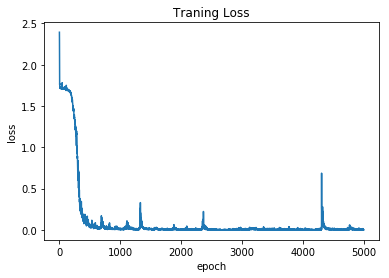

In [10]:
plt.plot(model_loss)
plt.title('Traning Loss')
plt.xlabel('epoch')
plt.show()